In [1]:
import os
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
tqdm.pandas()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIRETORIO_COHEBERT = "data"

DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/BERT_regressor/BERT_base_experimentos/" + DIRETORIO_COHEBERT

NOME_ARQUIVO_INPUT = 'bert_base_redacoes_cos_sim_texto_motivador_categoria.csv'

# 1. Setup colab GPU

In [4]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# 1.1 Attach torch to GPU

In [5]:
import torch
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 1.2 Install libraries

In [6]:
! pip install sklearn
! pip install -U sentence-transformers
! python -m spacy download pt_core_news_sm
! pip install tensorflow h5py
! pip install --upgrade tensorflow h5py

import nltk
nltk.download('punkt')

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d174b93f789c6470cd56f3fca55b4f491fb9aa96a6c1c6e09414a1263c6d0cbf
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 2. Load dataset pré-processado

---



In [7]:
df=pd.read_csv(f"{DIRETORIO_DRIVE}/{NOME_ARQUIVO_INPUT}")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         2653 non-null   int64  
 1   redacao                                    2653 non-null   object 
 2   nota_competencia_2                         2653 non-null   int64  
 3   nota_geral                                 2653 non-null   int64  
 4   tema                                       2653 non-null   object 
 5   texto_motivador                            2653 non-null   object 
 6   categoria                                  2653 non-null   object 
 7   sentencas_redacao                          2653 non-null   object 
 8   sentencas_texto_motivador                  2653 non-null   object 
 9   qtd_sentencas_redacao                      2653 non-null   int64  
 10  qtd_sentencas_texto_moti

,id,redacao,nota_competencia_2,nota_geral,tema,texto_motivador,categoria,sentencas_redacao,sentencas_texto_motivador,qtd_sentencas_redacao,...,len_texto_motivador,tokens_sentencas_redacao,tokens_sentencas_texto_motivador,tokens_sentencas_tema,avg_len_sentencas_redacao,avg_len_sentencas_texto_motivador,avg_bert_tokens_sentencas_texto_motivador,avg_bert_tokens_sentencas_redacao,cos_sim_last_hidden_layers,cos_sim_sentence_mean_pooled
301,1167,as faces news hoje são um problema mundial. me...,120,520,informação e sociedade: o combate às fake news...,"""as fake news são mais do que simplesmente not...",sociedade e cultura,['as faces news hoje são um problema mundial.'...,"['""as fake news são mais do que simplesmente n...",17,...,1034,"[['[CLS]', 'as', 'faces', 'ne', '##ws', 'hoje'...","[['[CLS]', '""', 'as', 'fa', '##ke', 'ne', '##w...","['[CLS]', 'informação', 'e', 'sociedade', ':',...",104.411765,129.250000,31.250000,26.176471,0.762024,0.890763
818,2342,é notório que as conquistas pessoais no mundo ...,160,640,o suicídio entre os jovens: como resolver esse...,o suicídio pode ser causado por vários fatores...,saúde,['é notório que as conquistas pessoais no mund...,['o suicídio pode ser causado por vários fator...,11,...,1831,"[['[CLS]', 'é', 'no', '##tório', 'que', 'as', ...","[['[CLS]', 'o', 'suicídio', 'pode', 'ser', 'ca...","['[CLS]', 'o', 'suicídio', 'entre', 'os', 'jov...",193.272727,152.583333,35.000000,41.545455,0.842735,0.926292
520,1778,a partir dos conceitos apresentados em relação...,120,600,reforma da previdência: uma solução ou um prob...,"reforma da previdência social, ou simplesmente...",sociedade e cultura,['a partir dos conceitos apresentados em relaç...,"['reforma da previdência social, ou simplesmen...",2,...,1937,"[['[CLS]', 'a', 'partir', 'dos', 'conceitos', ...","[['[CLS]', 'reforma', 'da', 'prev', '##idência...","['[CLS]', 'reforma', 'da', 'prev', '##idência'...",858.500000,176.090909,41.272727,167.500000,0.811427,0.870214
303,1171,é indubitável que a fome é um problema social ...,120,520,fome: um retrato da desigualdade social no brasil,a fome é a situação na qual a alimentação que ...,economia,['é indubitável que a fome é um problema socia...,['a fome é a situação na qual a alimentação qu...,8,...,2026,"[['[CLS]', 'é', 'indu', '##bit', '##ável', 'qu...","[['[CLS]', 'a', 'fome', 'é', 'a', 'situação', ...","['[CLS]', 'fome', ':', 'um', 'retrato', 'da', ...",195.375000,96.476190,21.666667,42.875000,0.873027,0.903013
2325,6236,após o primeiro capítulo da novela ba...,200,920,o conceito de famlia pode ou no pode mudar?,a cmara dos deputados est promovendo em seu si...,sociedade e cultura,['após o primeiro capítulo da novela ...,['a cmara dos deputados est promovendo em seu ...,13,...,1101,"[['[CLS]', 'após', 'o', 'primeiro', 'capítulo'...","[['[CLS]', 'a', 'cm', '##ara', 'dos', 'deputad...","['[CLS]', 'o', 'conceito', 'de', 'fam', '##lia...",173.307692,110.100000,26.800000,33.461538,0.568679,0.786121


In [8]:
# Extrai redacoes, textos motivadores e notas para treinamento

redacoes = df.redacao.values
textos_motivadores = df.texto_motivador.values
notas = df.nota_competencia_2.values

# 3. Tokenização e preparação de textos para treinamento no BERTimbau

In [9]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads

model_name = 'neuralmind/bert-base-portuguese-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
bertimbau = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).cuda()

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3.1 Tamanho dos textos e Attention Mask

Redaçãoes e textos motivadores obviamente possuem tamanhos variáveis e existem duas formas do BERT lidar com isso:



1.   Textos devem ser truncados ou a técnica de *padding* deve ser aplicada para que os textos tenham um tamanho fixo `e.g. 300`
2.   Textos devem ser menores do que o limite máximo de `512` tokens



# 3.2 Tokenização de redações

In [10]:
# Tokenize todas as redações e realiza o mapeamento de tokens para os seus respectivos input_ids

r_input_ids = []
r_attention_masks = []

for redacao in redacoes:
    # `encode_plus` will:
    #   (1) Tokeniza redação.
    #   (2) Add `[CLS]` token no inicio do texto.
    #   (3) Add `[SEP]` token no fim do texto.
    #   (4) Mapeamento de tokens para seus IDs.
    #   (5) Padding `max_length`
    #   (6) Cria attention masks para os tokens do tipo [PAD].
    r_encoded_dict = tokenizer.encode_plus(
                        redacao,                      # Redação.
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 512,             # Pad redação.
                        padding = 'max_length',
                        return_attention_mask = True, # Constrói attn. masks.
                        return_tensors = 'pt',        # Retorna pytorch tensors.
                   )


    r_input_ids.append(r_encoded_dict['input_ids'])
    r_attention_masks.append(r_encoded_dict['attention_mask'])

# 3.3 Tokenização de redações

In [11]:
# Tokenize todas as redações e realiza o mapeamento de tokens para os seus respectivos input_ids

tm_input_ids = []
tm_attention_masks = []

for tm in textos_motivadores:
    # `encode_plus` will:
    #   (1) Tokeniza texto motivador.
    #   (2) Add `[CLS]` token no inicio do texto.
    #   (3) Add `[SEP]` token no fim do texto.
    #   (4) Mapeamento de tokens para seus IDs.
    #   (5) Padding `max_length`
    #   (6) Cria attention masks para os tokens do tipo [PAD].
    tm_encoded_dict = tokenizer.encode_plus(
                        tm,                           # Texto motivador
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 512,             # Pad redação.
                        padding = 'max_length',
                        return_attention_mask = True, # Constrói attn. masks.
                        return_tensors = 'pt',        # Retorna pytorch tensors.
                   )


    tm_input_ids.append(tm_encoded_dict['input_ids'])
    tm_attention_masks.append(tm_encoded_dict['attention_mask'])

In [12]:
print(len(r_input_ids))

2653


# 4. Transforma inputs em torches

In [13]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Transoforma lista de notas em uma torch
notas = torch.tensor(notas)

# Concatena lista de torchs

r_input_ids = torch.cat(r_input_ids, dim=0)
tm_input_ids = torch.cat(tm_input_ids, dim=0)
r_attention_masks = torch.cat(r_attention_masks, dim=0)
tm_attention_masks = torch.cat(tm_attention_masks, dim=0)

In [14]:
# Adiciona torches para rodarem na GPU

notas = notas.to(device)
r_input_ids = r_input_ids.to(device)
tm_input_ids = tm_input_ids.to(device)
r_attention_masks = r_attention_masks.to(device)
tm_attention_masks = tm_attention_masks.to(device)

In [15]:
# Set types

notas = notas.float()
r_input_ids = r_input_ids.long()
tm_input_ids = tm_input_ids.long()
r_attention_masks = r_attention_masks.float()
tm_attention_masks = tm_attention_masks.float()

# 5. Divide datasets em treinamento e validação

In [16]:
from torch.utils.data import Dataset, DataLoader

class PreTokenizedDataset(Dataset):
    def __init__(self, r_input_ids_list, r_attention_masks_list, tm_input_ids_list, tm_attention_masks_list, notas):
        self.r_input_ids_list = r_input_ids_list
        self.r_attention_masks_list = r_attention_masks_list
        self.tm_input_ids_list = tm_input_ids_list
        self.tm_attention_masks_list = tm_attention_masks_list
        self.notas = notas

    def __len__(self):
        return len(self.notas)

    def __getitem__(self, idx):
        return {
            'r_input_ids': self.r_input_ids_list[idx],
            'r_attention_mask': self.r_attention_masks_list[idx],
            'tm_input_ids': self.tm_input_ids_list[idx],
            'tm_attention_mask': self.tm_attention_masks_list[idx],
            'nota_competencia_2': self.notas[idx]
        }

In [17]:
from torch.utils.data import RandomSampler, SequentialSampler

"""
  32 é o tamanho recomendado pelo artigo do Devlin para fine-tunning,
  porém batches maiores que 8 tem consumido mais RAM do que o colab (até mesmo o PRO oferece) que é de 15-20 GB
"""
BATCH_SIZE = 8

complete_dataset = PreTokenizedDataset(r_input_ids, r_attention_masks, tm_input_ids, tm_attention_masks, notas)
complete_dataloader = DataLoader(complete_dataset, sampler = RandomSampler(complete_dataset), batch_size = BATCH_SIZE)


print('{:>5,} complete training samples'.format(len(complete_dataset)))
print('{:>5,} complete dataloader batches'.format(len(complete_dataloader)))

2,653 complete training samples
  332 complete dataloader batches


# 6.1 Helper functions

In [18]:
import datetime
import matplotlib.pyplot as plt

In [19]:
def format_time(elapsed):
  '''
    Takes time in seconds and returns a string hh:mm:ss
  '''

  elapsed_rounded = int(round(elapsed))

  return str(datetime.timedelta(seconds=elapsed_rounded))


def get_mean_absolute_error(preds, labels):
    return torch.abs(preds - labels).mean().item()


def plot_train_val_losses(train_losses, val_losses, title="Loss vs Epochs", xlabel="Epochs", ylabel="RMSE Loss"):
    """
        Plots training and validation losses over epochs
    """

    epochs = range(1, len(train_losses) + 1)

    # Plot curves
    plt.plot(epochs, train_losses, color='r', label="Training Loss")
    plt.plot(epochs, val_losses, color='b', label="Validation Loss")

    # Naming the axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    plt.show()


# 6.2 Declara BertRegressor

In [20]:
import torch.nn as nn

class BertimbauRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bertimbau=False):

        super(BertimbauRegressor, self).__init__()
        # 768 * 2 por causa da concatenação
        D_in, D_out = 1536, 1

        # self.regressor = nn.Sequential(
        #     nn.Dropout(drop_rate),
        #     nn.Linear(D_in, D_out))

        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(1536, 512),  # First dense layer
            nn.ReLU(),             # Activation function
            nn.Dropout(drop_rate),
            nn.Linear(512, 128),   # Second dense layer
            nn.ReLU(),             # Activation function
            nn.Dropout(drop_rate),
            nn.Linear(128, 1)      # Final layer to predict grade
        )

    def forward(self, r_input_ids, r_attention_masks, tm_input_ids, tm_attention_masks):

        # print('======================')
        # print(f'r_input_ids.shape: {r_input_ids.shape}')
        # print(f'r_attention_masks.shape: {r_attention_masks.shape}')
        # print(f'tm_input_ids.shape: {tm_input_ids.shape}')
        # print(f'tm_attention_masks.shape: {tm_attention_masks.shape}')

        r_outputs = bertimbau(r_input_ids, r_attention_masks, output_hidden_states=True)
        r_class_label_output = r_outputs.hidden_states[-1][:,0,:]
        # print('======================')
        # print(f'r_class_label_output.shape: {r_class_label_output.shape}')


        # print(f'r_class_label_output: {r_outputs[1]}')
        # print(f'r_class_label_output: {r_outputs[0][:, 0, :]}')
        # print(f'len(r_class_label_output): {len(r_class_label_output[0])}')
        # print(f'r_class_label_output shape: {r_outputs.shape}')

        tm_outputs = bertimbau(tm_input_ids, tm_attention_masks, output_hidden_states=True)
        tm_class_label_output = tm_outputs.hidden_states[-1][:,0,:]
        # print(f'tm_class_label_output.shape: {tm_class_label_output.shape}')

        # print(f'tm_class_label_output: {tm_outputs[1]}')
        # print(f'tm_class_label_output: {tm_outputs[0][:, 0, :]}')
        # print(f'len(tm_class_label_output): {len(tm_class_label_output[0])}')
        # print(f'tm_class_label_output shape: {tm_outputs.shape}')

        concatenated_output = torch.cat((r_class_label_output, tm_class_label_output), dim=-1)
        # print(f'concatenated output: {concatenated_output.shape}')

        outputs = self.regressor(concatenated_output)
        # print('======================')
        # print(f'outputs after regressor: {outputs.shape}')
        return outputs


model = BertimbauRegressor(drop_rate=0.2)

# tells model to run on GPU
model.to(device)

BertimbauRegressor(
  (regressor): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1536, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(bertimbau.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (29794, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# 6.2 Fine tunning


*   Declara learning rate
*   Declara otimizador



In [22]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3 # O artigo do BERT recomenda de 2-4 epocas. Checar se 4 épocas não está causando over-fitting.

loss_function = nn.MSELoss()

LR = 2e-5 # recommended lrs -> 5e-5, 3e-5, 2e-5


total_steps = len(complete_dataloader) * EPOCHS

optimizer = AdamW(bertimbau.parameters(), lr=LR, eps = 1e-8)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

loss_function = torch.nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# 6.2 Loop de treinamento

In [23]:
import time
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from sklearn.model_selection import KFold
import numpy as np
import copy
import os

NUM_FOLDS = 10  # Adjust based on your dataset size and requirements

overall_train_loss_values = []
overall_val_loss_values = []
overall_train_mae_values = []
overall_val_mae_values = []

all_fold_time = 0

def train_with_cross_validation(model, optimizer, scheduler, loss_function, epochs, dataset, device, save_path, clip_value=2, logging_interval=40):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_mae = float('inf')  # Initialize with a high number

    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        print(f"\n=================== Fold {fold + 1} / {NUM_FOLDS} ======================")

        fold_train_loss = 0
        fold_train_mae = 0
        fold_val_loss = 0
        fold_val_mae = 0
        global all_fold_time

        fold_t0 = time.time()

        assert max(train_indices) < len(dataset) and max(val_indices) < len(dataset)

        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

        val_subset = torch.utils.data.Subset(dataset, val_indices)
        val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        # Save current fold datasets
        folds_save_dir = os.path.join(save_path, f"00_LR_{str(LR).replace('-', '_')}")
        if not os.path.exists(folds_save_dir):
            os.makedirs(folds_save_dir)

        torch.save(train_indices, os.path.join(folds_save_dir, f'train_indices_fold_{fold+1}.pt'))
        torch.save(val_indices, os.path.join(folds_save_dir, f'val_indices_fold_{fold+1}.pt'))


        for epoch in range(epochs):
            print(f"\n========== Epoch {epoch+1} / {epochs} ==========")

            epoch_start_time = time.time()

            # Training Phase
            model.train()
            total_loss = 0
            mean_absolute_error = 0

            for batch in train_dataloader:

                model.zero_grad() # Zero the gradients on each iteration
                optimizer.zero_grad()

                # Unpack this training batch from our dataloader and copy each tensor to the GPU.
                batch_r_input_ids = batch['r_input_ids'].to(device)
                batch_r_attention_masks = batch['r_attention_mask'].to(device)
                batch_tm_input_ids = batch['tm_input_ids'].to(device)
                batch_tm_attention_masks = batch['tm_attention_mask'].to(device)
                batch_labels = batch['nota_competencia_2'].to(device)


                outputs = model(
                    r_input_ids=batch_r_input_ids,
                    r_attention_masks=batch_r_attention_masks,
                    tm_input_ids=batch_tm_input_ids,
                    tm_attention_masks=batch_tm_attention_masks
                )

                loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
                total_loss += loss.item()

                mean_absolute_error += get_mean_absolute_error(outputs, batch_labels)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloader)
            avg_train_mae = mean_absolute_error / len(train_dataloader)

            overall_train_loss_values.append(avg_train_loss)
            overall_train_mae_values.append(avg_train_mae)

            #======================================================
            #                    Validation
            #======================================================

            model.eval()

            total_val_loss = 0
            mean_absolute_error = 0

            for batch in val_dataloader:
                batch_r_input_ids = batch['r_input_ids'].to(device)
                batch_r_attention_masks = batch['r_attention_mask'].to(device)
                batch_tm_input_ids = batch['tm_input_ids'].to(device)
                batch_tm_attention_masks = batch['tm_attention_mask'].to(device)
                batch_labels = batch['nota_competencia_2'].to(device)


                with torch.no_grad():
                    outputs = model(
                        r_input_ids=batch_r_input_ids,
                        r_attention_masks=batch_r_attention_masks,
                        tm_input_ids=batch_tm_input_ids,
                        tm_attention_masks=batch_tm_attention_masks
                    )

                    loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
                    total_val_loss += loss.item()
                    mean_absolute_error += get_mean_absolute_error(outputs, batch_labels)

            avg_val_loss = total_val_loss / len(val_dataloader)
            avg_val_mae = mean_absolute_error / len(val_dataloader)

            overall_val_loss_values.append(avg_val_loss)
            overall_val_mae_values.append(avg_val_mae)

            fold_train_loss += avg_train_loss
            fold_train_mae += avg_train_mae
            fold_val_loss += avg_val_loss
            fold_val_mae += avg_val_mae

            if avg_val_mae < best_val_mae:
                best_val_mae = avg_val_mae
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"New best model found at fold {fold + 1} with MAE: {avg_val_mae}\n")

            print(f"Training Loss: {avg_train_loss:.2f}, MAE: {avg_train_mae:.2f}")
            print(f"Validation Loss: {avg_val_loss:.2f}, MAE: {avg_val_mae:.2f}")

            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            print(f"Epoch {epoch + 1}/{epochs} took: {format_time(epoch_time)}")

        fold_avg_train_loss = fold_train_loss / epochs
        fold_avg_train_mae = fold_train_mae / epochs
        fold_avg_val_loss = fold_val_loss / epochs
        fold_avg_val_mae = fold_val_mae / epochs

        print("================================")
        print(f"\nFold {fold + 1} Average Metrics\n")

        print(f"fold_{fold + 1}_train_loss_values: {overall_train_loss_values[-epochs:]}")
        print(f"fold_{fold + 1}_val_loss_values: {overall_val_loss_values[-epochs:]}")
        print(f"fold_{fold + 1}_train_mae_values: {overall_train_mae_values[-epochs:]}")
        print(f"fold_{fold + 1}_val_mae_values: {overall_val_mae_values[-epochs:]}")

        print(f"Average Training Loss: {fold_avg_train_loss:.2f}")
        print(f"Average Training MAE: {fold_avg_train_mae:.2f}")
        print(f"Average Validation Loss: {fold_avg_val_loss:.2f}")
        print(f"Average Validation MAE: {fold_avg_val_mae:.2f}")

        fold_time = time.time() - fold_t0
        all_fold_time += fold_time
        print(f"\nFold {fold + 1} took: {format_time(fold_time)}")

    # Print overeall train and validation loss and mae
    print(f"overall_train_loss_values{overall_train_loss_values}")
    print(f"overall_val_loss_values{overall_val_loss_values}")
    print(f"overall_train_mae_values{overall_train_mae_values}")
    print(f"overall_val_mae_values{overall_val_mae_values}")

    # Calculate overall average metrics
    avg_train_loss = np.mean(overall_train_loss_values)
    avg_val_loss = np.mean(overall_val_loss_values)
    avg_train_mae = np.mean(overall_train_mae_values)
    avg_val_mae = np.mean(overall_val_mae_values)

    print(f"\n================================ Training complete! ================================")
    print("Overall summary:")
    print(f"Average Training Loss: {avg_train_loss:.2f}")
    print(f"Average Validation Loss: {avg_val_loss:.2f}")
    print(f"Average Training MAE: {avg_train_mae:.2f}")
    print(f"Average Validation MAE: {avg_val_mae:.2f}")
    print(f"All folds took: {format_time(all_fold_time)}")

    # Load best model
    model.load_state_dict(best_model_wts)
    print(f"Best model was from fold with MAE: {best_val_mae:.2f}")

    return model, overall_train_loss_values, overall_val_loss_values, overall_train_mae_values, overall_val_mae_values


# 7.1 Plot errors

In [24]:
save_dir = f"/content/drive/MyDrive/Colab Notebooks/BERT_regressor/BERT_base_experimentos/treinamentos/k-fold/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [25]:
model, train_loss_values, val_loss_values, mae_train_values, mae_val_values = train_with_cross_validation(model, optimizer, scheduler, loss_function, EPOCHS,
              complete_dataset, device, save_dir, clip_value=2)


=================== Fold 1 / 10 ======================

========== Epoch 1 / 3 ==========
New best model found at fold 1 with MAE: 129.10325151331284

Training Loss: 17740.18, MAE: 128.19
Validation Loss: 17846.55, MAE: 129.10
Epoch 1/3 took: 0:07:42

========== Epoch 2 / 3 ==========
New best model found at fold 1 with MAE: 129.06497753367705

Training Loss: 17645.85, MAE: 127.83
Validation Loss: 17836.52, MAE: 129.06
Epoch 2/3 took: 0:07:43

========== Epoch 3 / 3 ==========
New best model found at fold 1 with MAE: 129.04913442275102

Training Loss: 17628.71, MAE: 127.76
Validation Loss: 17832.36, MAE: 129.05
Epoch 3/3 took: 0:07:43

Fold 1 Average Metrics

fold_1_train_loss_values: [17740.17551016409, 17645.854812264843, 17628.712972277383]
fold_1_val_loss_values: [17846.5495892693, 17836.518497242647, 17832.359633501837]
fold_1_train_mae_values: [128.18539071481763, 127.83437967459892, 127.75534305125973]
fold_1_val_mae_values: [129.10325151331284, 129.06497753367705, 129.04913442

In [26]:
print(f'train_loss_values: {train_loss_values}')
print(f'val_loss_values: {val_loss_values}')
print(f'mae_train_values: {mae_train_values}')
print(f'mae_val_values: {mae_val_values}')

train_loss_values: [17740.17551016409, 17645.854812264843, 17628.712972277383, 17657.71618284908, 17638.527925114966, 17659.404326269858, 17701.784868833613, 17696.846976902172, 17697.822778401965, 17694.918919183736, 17702.249144283025, 17694.429929191054, 17758.02250339674, 17752.07459761706, 17772.859420725334, 17686.301636966975, 17682.732438205476, 17676.709392636916, 17743.044082488505, 17727.78398372178, 17724.95248157922, 17761.878190975127, 17771.840846441264, 17752.854969037417, 17647.335764396947, 17631.69760856501, 17640.670225621863, 17622.23720670464, 17605.5641036528, 17614.630967156147]
val_loss_values: [17846.5495892693, 17836.518497242647, 17832.359633501837, 17859.59485581342, 17859.59485581342, 17859.59485581342, 17427.39194623162, 17427.39194623162, 17427.39194623162, 17528.149442784925, 17528.149442784925, 17528.149442784925, 16940.428969439337, 16940.428969439337, 16940.428969439337, 17396.684728285847, 17396.684728285847, 17396.684728285847, 16961.925680721506, 

In [27]:
import matplotlib.pyplot as plt

def plot_train_val_losses(train_losses, val_losses, title="Loss vs Epochs", xlabel="Epochs", ylabel="RMSE Loss"):
    """
        Plots training and validation losses over epochs
    """

    epochs = range(1, len(train_losses) + 1)

    # Plot curves
    plt.plot(epochs, train_losses, color='r', label="Training Loss")
    plt.plot(epochs, val_losses, color='b', label="Validation Loss")

    # Naming the axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    plt.show()


# Overal performance

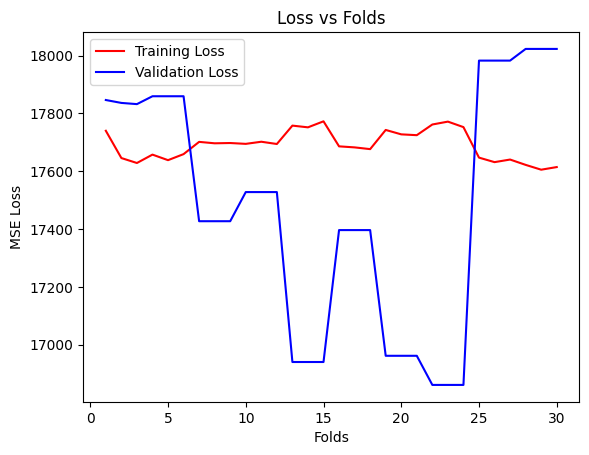

In [28]:
plot_train_val_losses(train_loss_values, val_loss_values, title="Loss vs Folds", xlabel="Folds", ylabel="MSE Loss")

# Best epoch performance

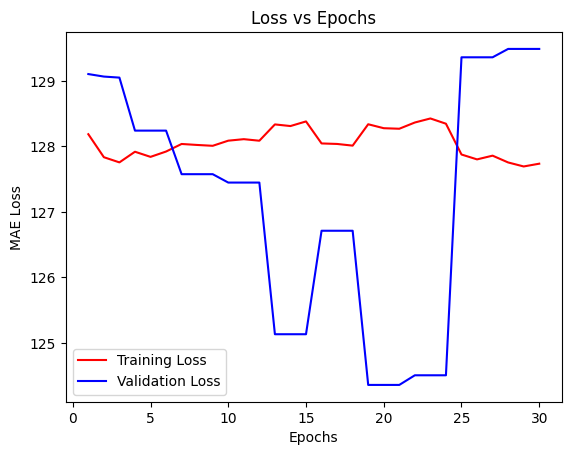

In [29]:
plot_train_val_losses(mae_train_values, mae_val_values,  ylabel="MAE Loss")

# 8 Predictions

In [30]:
def predict(model, tokenizer, essay, auxiliary_text):
    """
    Make predictions with the BertimbauRegressor model.

    Args:
    - model (torch.nn.Module): The trained BertimbauRegressor model.
    - tokenizer (Transformers Tokenizer): The tokenizer used for preprocessing.
    - essay (str): The main text of the essay.
    - auxiliary_text (str): Additional or auxiliary information about the essay.

    Returns:
    - float: The predicted grade for the essay.
    """

    model.to(device)

    # Tokenize the main essay and auxiliary text separately
    essay_tokens = tokenizer(essay, return_tensors="pt", truncation=True, padding=True, max_length=500).to(device)
    auxiliary_tokens = tokenizer(auxiliary_text, return_tensors="pt", truncation=True, padding=True, max_length=500).to(device)

    # Ensure model is in evaluation mode
    model.eval()

    # No gradient computation needed during prediction
    with torch.no_grad():
        prediction = model(essay_tokens['input_ids'], essay_tokens['attention_mask'], auxiliary_tokens['input_ids'], auxiliary_tokens['attention_mask'])

    # Extract the grade from the tensor
    return prediction.item()

In [31]:
import random

rand = random.randrange(0, len(df))

redacao = df.loc[rand, 'redacao']
texto_motivador = df.loc[rand, 'texto_motivador']
nota = df.loc[rand, 'nota_competencia_2']

print(f'redacao: {redacao[:100]}')
print(f'texto motivador: {texto_motivador[:100]}')
print(f'nota: {nota}')

pred = predict(model, tokenizer, redacao, texto_motivador)
print(f'pred: {pred}')

redacao: transgênicos, ou          organismo          geneticamente          modificados          são seres q
texto motivador: a discusso no chega a ser recente, mas nem por isso deixa de ter grande importncia. com a evoluo da 
nota: 160
pred: 2.6103432178497314


In [4]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_lr_performance_comparison(lr_metrics, chart_type='line'):
    """
    Plots a comparison of validation loss and MAE for different learning rates across folds using unique colors for each line.

    Args:
    lr_metrics (dict): A dictionary where keys are learning rates and values are dictionaries containing lists of validation loss and MAE for each fold.
    chart_type (str): Type of chart to plot ('line' or 'bar').
    """
    learning_rates = list(lr_metrics.keys())
    n_folds = len(next(iter(lr_metrics.values()))['loss'])  # Assuming all learning rates have the same number of folds
    color_cycle = plt.cm.tab10(np.linspace(0, 1, len(learning_rates)*2))  # Create a color cycle

    plt.figure(figsize=(12, 6))
    color_iter = itertools.cycle(color_cycle)  # Iterator for colors

    for lr in learning_rates:
        folds = range(1, n_folds + 1)
        color = next(color_iter)

        if chart_type == 'line':
            plt.plot(folds, lr_metrics[lr]['loss'], label=f'LR={lr} Loss', color=color)
            plt.plot(folds, lr_metrics[lr]['mae'], label=f'LR={lr} MAE', color=color, linestyle='--')
        elif chart_type == 'bar':
            plt.bar([x - 0.1 + 0.2 * i for i, x in enumerate(folds)],
                    lr_metrics[lr]['loss'], width=0.1, label=f'LR={lr} Loss', color=color)
            plt.bar([x + 0.1 + 0.2 * i for i, x in enumerate(folds)],
                    lr_metrics[lr]['mae'], width=0.1, label=f'LR={lr} MAE', color=color)

    plt.title('Treinamento Loss vs MAE - comparação ao longo de diferentes taxas de aprendizado')
    plt.xlabel('Folds')
    plt.ylabel('MSE Loss & MAE')
    plt.xticks(range(1, n_folds + 1))
    plt.legend()
    plt.tight_layout()

    plt.show()

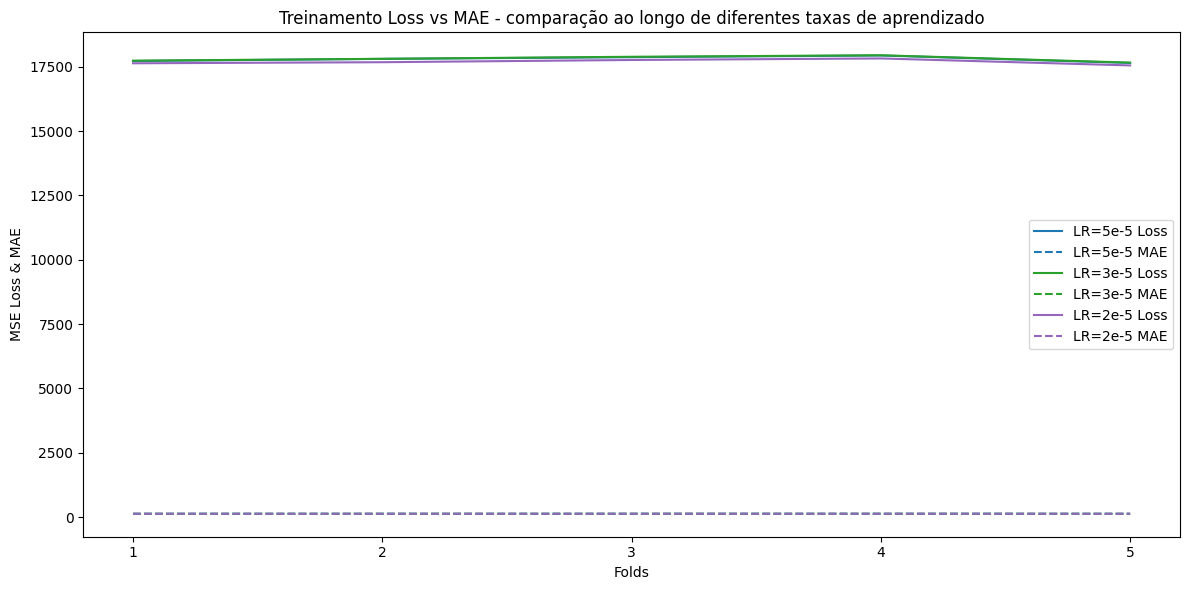

In [5]:
lr_metrics = {
    '5e-5': {'loss': [17721.79, 17804.2, 17870.17, 17936.18, 17646.00], 'mae': [128.1, 128.42, 128.76, 129.15, 127.83]},
    '3e-5': {'loss': [17735.11, 17806.66, 17886.36, 17945.02, 17659.43], 'mae': [128.15, 128.44, 128.82, 129.19, 127.89]},
    '2e-5': {'loss': [17633.15, 17675.1, 17761.4, 17821.22, 17550.11], 'mae': [127.76, 127.93, 128.36, 128.72, 127.46]}
}

plot_lr_performance_comparison(lr_metrics, chart_type='line')  # or 'bar'


# 9 Save the model

In [32]:
save_dir = f"/content/drive/MyDrive/Colab Notebooks/BERT_regressor/bert_base/treinamentos/k-fold"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [33]:
torch.save(model.state_dict(), f"{save_dir}/LR_{str(LR).replace('-', '_')}/bert_base_cls_tokens_lr_{str(LR)}_{EPOCHS}_epochs.json")

In [34]:
bertimbau_regressor = BertimbauRegressor()
bertimbau_regressor.load_state_dict(torch.load(f"{save_dir}/00_LR_{str(LR).replace('-', '_')}/bert_base_cls_tokens_lr_{str(LR)}_{EPOCHS}_epochs.json"))
bertimbau_regressor.eval()

BertimbauRegressor(
  (regressor): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1536, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=1, bias=True)
  )
)